In [1]:
from send_to_racing import bbox,depth_values;
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout ,LeakyReLU , BatchNormalization
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_model_optimization as tfmot
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import keras
import time

In [2]:
X = np.array(bbox)
Y = np.array(depth_values)
df = pd.DataFrame(X , columns= ['class' , 'x ', 'y','w','h', 'confidence'])
df['ratio']  = df['h']/df['w']
#print(df['ratio'])
df = df[['y' , 'w' , 'h' , 'confidence' , 'class' , 'ratio']]#including class here becasue of the mention in ADR(THINK LATER) -will check during feature engineering
X = np.asarray(df).astype('float32')
#checked that ratio is always >1 ,if for any row it is less than 1 , then need to switch the w and h for that row
counter = 0
for rows in X:
    if rows[5]<1:
        counter= counter+1
X = torch.from_numpy(X)
print(counter)
print(X.shape)

0
torch.Size([441, 6])


In [3]:

X_train, X_test, Y_train, Y_test  = train_test_split(X,Y,test_size=0.1, shuffle=True)#X_test for final check .mostly validation will only be used for the model
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [25]:
#MODEL IMPLEMENTATION
#hyperparameter values obtained from hyperparameter_tuning.ipynb
model = keras.Sequential()
model.add(Dense(10, input_dim = X_train.shape[1], activation='relu'))
model.add(Dropout(0.1))
model.add(LeakyReLU(alpha=0.01))
BatchNormalization(axis  = 1)
model.add(Dense(1,activation='linear'))#final output returns a linear function



#LEARNING RATE SCHEDULER
def lr_schedule(epoch, lr):
    if epoch < 30:
        return lr
    else:
        if epoch%5==0: #check (declines too rapidly without this)
            return lr * math.exp(-0.1)
        else:
            return lr

callback = LearningRateScheduler(lr_schedule)





custom_optimizer = optimizers.Adam(learning_rate = 0.01)
model.compile(loss = 'mean_squared_error' , optimizer = custom_optimizer)

history = model.fit(X_train , Y_train , epochs = 50 , batch_size=32,validation_split = 0.4 ,callbacks=[callback] )
#,validation_split = 0.4

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 30.6836 - val_loss: 23.6623 - learning_rate: 0.0100
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.2646 - val_loss: 17.3833 - learning_rate: 0.0100
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.5527 - val_loss: 12.0590 - learning_rate: 0.0100
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.0868 - val_loss: 7.6782 - learning_rate: 0.0100
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0294 - val_loss: 4.8629 - learning_rate: 0.0100
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4200 - val_loss: 3.3898 - learning_rate: 0.0100
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4532 - val_loss: 2.4756 - learning_rate: 0.0100
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8416 - val_loss: 1.9046 - learning_rate: 0.0100
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7953 - val_loss: 1.5014 - learning_rate: 0.0100
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s

In [14]:
#QUANITZED MODEL
#quantize the model for reducing latency

# Convert the model to TensorFlow Lite format with post-training quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()


# Save the quantized model
with open('post_training_quantized_model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /var/folders/m2/kzz86mfd0kb14bcjpm5dhvw80000gn/T/tmphmm8v8mt/assets


INFO:tensorflow:Assets written to: /var/folders/m2/kzz86mfd0kb14bcjpm5dhvw80000gn/T/tmphmm8v8mt/assets


Saved artifact at '/var/folders/m2/kzz86mfd0kb14bcjpm5dhvw80000gn/T/tmphmm8v8mt'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 6), dtype=tf.float32, name='keras_tensor_11')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  11196832400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11196832224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11197516608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  11197516432: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1721480651.751798 27503924 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1721480651.752025 27503924 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2024-07-20 18:34:11.752376: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/m2/kzz86mfd0kb14bcjpm5dhvw80000gn/T/tmphmm8v8mt
2024-07-20 18:34:11.752599: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-07-20 18:34:11.752604: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/m2/kzz86mfd0kb14bcjpm5dhvw80000gn/T/tmphmm8v8mt
2024-07-20 18:34:11.754942: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-07-20 18:34:11.755270: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-07-20 18:34:11.772032: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle a

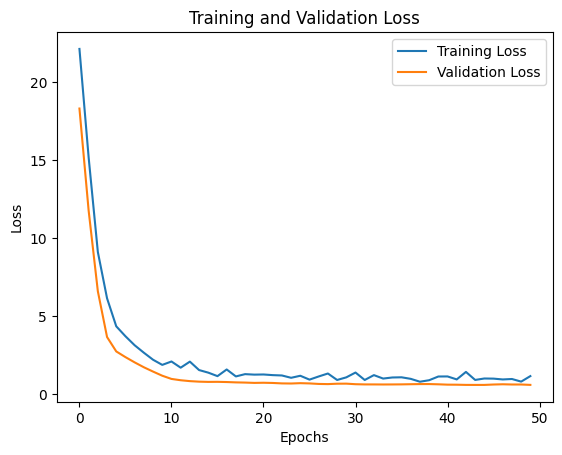

In [16]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [34]:


start_time = time.time()
predictions= model.predict(X_test)
end_time = time.time()


print(f"average time taken{(end_time-start_time)/len(X_test)}")
mse = model.evaluate(X_test, Y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
average time taken0.0009210427602132161
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2354 


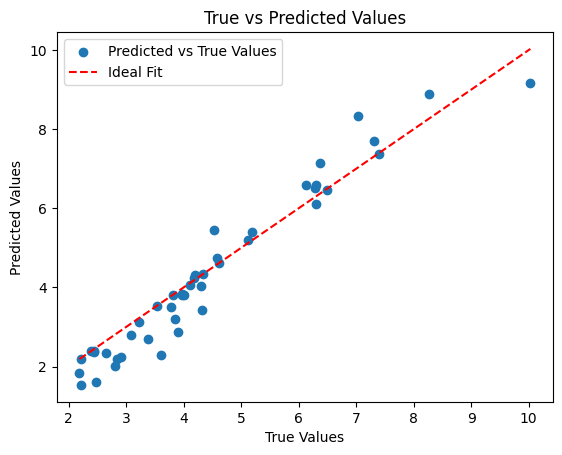

In [18]:
plt.scatter(Y_test, predictions, label='Predicted vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--', label='Ideal Fit')
plt.legend()
plt.show()